# Data Scientist Challenge

## Goal
In this notebook I will create a model to predict wether a student will pass a certain test at the university or not.

## importing libraries and data

In [366]:
# import the necessary libraries
import pandas as pd
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [212]:
# connect to database

load_dotenv()

DB_STRING = os.getenv('DB_STRING')

db = create_engine(DB_STRING)


In [213]:
# create a sql query with path of data
query_string = "SELECT * FROM takemehome.triad"


In [214]:
# import the data
df_sqlalchemy = pd.read_sql(query_string, db)
df_sqlalchemy.head()

,sex,lang,country,age,hours_studied,dojo_class,test_prep,pass,notes
0,Male,Japanese,Japan,20,10.578594,True,False,True,None
1,Male,Japanese,Japan,22,7.814520,False,False,True,None
2,Male,Japanese,Japan,27,4.213682,False,False,True,None
3,Male,Japanese,Japan,24,NaN,False,False,True,None
4,Female,Japanese,Japan,21,3.248907,False,False,False,None


In [215]:
# Save dataframe as .csv file
df_sqlalchemy.to_csv("takemehome_data.csv", index=False)

In [216]:
# rename dataframe

df = df_sqlalchemy

## Part 1: Analysis
* Describe the demographic details of people most likely to pass the test
* Describe the efficacy of the two interventions - the test prep course and the Dojo class
* Identify any other interesting trends from the data set and offer some analysis as to their importance or cause.

### getting to know the data

In [217]:
df.head()

,sex,lang,country,age,hours_studied,dojo_class,test_prep,pass,notes
0,Male,Japanese,Japan,20,10.578594,True,False,True,None
1,Male,Japanese,Japan,22,7.814520,False,False,True,None
2,Male,Japanese,Japan,27,4.213682,False,False,True,None
3,Male,Japanese,Japan,24,NaN,False,False,True,None
4,Female,Japanese,Japan,21,3.248907,False,False,False,None


In [218]:
df.shape

(5000, 9)

the dataframe consists 5000 rows and 9 columns

In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sex            5000 non-null   object 
 1   lang           5000 non-null   object 
 2   country        5000 non-null   object 
 3   age            5000 non-null   int64  
 4   hours_studied  3018 non-null   float64
 5   dojo_class     5000 non-null   bool   
 6   test_prep      5000 non-null   bool   
 7   pass           5000 non-null   bool   
 8   notes          772 non-null    object 
dtypes: bool(3), float64(1), int64(1), object(4)
memory usage: 249.2+ KB


In [220]:
# see how many values are missing
df.isnull().sum()

sex                 0
lang                0
country             0
age                 0
hours_studied    1982
dojo_class          0
test_prep           0
pass                0
notes            4228
dtype: int64

In [221]:
# checking for duplicates
df.duplicated().sum()

1113

there are 1113 duplicates in the data set!

In [222]:
# having a closer look at the duplicates

if (duplicated := df.duplicated(keep=False)).any():
    some_duplicates = df[duplicated].sort_values(by=df.columns.to_list()).head(20)
    print(f"Dataframe has one or more duplicated rows, for example:\n{some_duplicates}")

Dataframe has one or more duplicated rows, for example:
         sex      lang      country  age  hours_studied  dojo_class   
1762  Female   English    Australia   30            NaN       False  \
1763  Female   English    Australia   30            NaN       False   
2833  Female   English  New Zealand   18            NaN       False   
3312  Female   English  New Zealand   18            NaN       False   
887   Female   English  New Zealand   19            NaN       False   
1719  Female   English  New Zealand   19            NaN       False   
2420  Female   English           UK   19            NaN       False   
2474  Female   English           UK   19            NaN       False   
1839  Female   English          USA   21            NaN       False   
4537  Female   English          USA   21            NaN       False   
1796  Female   English          USA   22            NaN       False   
2518  Female   English          USA   22            NaN       False   
1165  Female   Italia

In [223]:
df['lang'].value_counts()

lang
Japanese    4022
English      528
Italian      145
Spanish      132
French       128
Finnish       45
Name: count, dtype: int64

In [224]:
df['country'].value_counts()

country
Japan          4022
Italy           145
USA             140
Australia       134
New Zealand     131
France          128
UK              123
Mexico           73
Spain            59
Finland          45
Name: count, dtype: int64

In [225]:
df.describe()

,age,hours_studied
count,5000.000000,3018.000000
mean,25.873400,4.964076
std,7.349978,3.203037
min,18.000000,0.139203
25%,20.000000,2.555823
50%,24.000000,4.247235
75%,30.000000,6.660737
max,50.000000,24.259314


summarize first insights of the data:

* the mean age is 25.87, the median age is 24; 50 % of the students are between 20 and 30 years old, the youngest students are 18, the oldest are 50
* the mean of hours studied are 4.96 hours, the median are 4.24 hours, 50 % of the students studied between 2.56 and 6.67 hours, the minimum was 0.14 hour, the maximum 24.26 hours



* there are 3 object categories which could be converted to a categorical variable
* hours studied has a lot of missing values (1982)
* there are a lot of duplicates in the dataset (1113), but it is not unlikely, that there exists two persons with the same age, gender and nationality etc. in a dataset of students, so I will leave the duplicates in
* notes isn't usefull at all since it is an open text field and was not filled out most of the times, so it can be dropped
* there are some booleans which values need to be converted to 0 and 1
* the rest of the data is complete 

In [226]:
# change object to categorical type
df[['sex', 'lang', 'country']] = df[['sex', 'lang', 'country']].astype('category')
df.dtypes

sex              category
lang             category
country          category
age                 int64
hours_studied     float64
dojo_class           bool
test_prep            bool
pass                 bool
notes              object
dtype: object

In [227]:
# drop column "notes"
df_clean = df.drop("notes", axis=1)

In [228]:
# replace booleans with 0 and 1

# create a list of all the boolean columns
column_list = ['dojo_class','test_prep','pass']

# replace "yes" with 1
df_clean['dojo_class'] = df_clean['dojo_class'].replace('True', 1)
df_clean['dojo_class'] = df_clean['dojo_class'].replace('False', 0)

### Describe the demographic details of people most likely to pass the test

#### building some hypothesis
H1: Women are more likely to pass the test than men <br>
H2: coming from Japan will increase the likelihood of passing the test  <br>
H3: the more hours the students studied, the more likely they passed the test  <br>
H4: students who doing the doho class or the test prep will pass the test more likely  <br>

In [229]:
df_clean.head()

,sex,lang,country,age,hours_studied,dojo_class,test_prep,pass
0,Male,Japanese,Japan,20,10.578594,True,False,True
1,Male,Japanese,Japan,22,7.814520,False,False,True
2,Male,Japanese,Japan,27,4.213682,False,False,True
3,Male,Japanese,Japan,24,NaN,False,False,True
4,Female,Japanese,Japan,21,3.248907,False,False,False


/Users/angelina/neuefische/ds-take-me-home/.venv/lib/python3.11/site-packages/seaborn/_stats/counting.py:137: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  bin_edges = np.histogram_bin_edges(vals, bins, binrange, weight)
/Users/angelina/neuefische/ds-take-me-home/.venv/lib/python3.11/site-packages/seaborn/_stats/counting.py:176: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, edges = np.histogram(vals, **bin_kws, weights=weights, density=density)


<Axes: xlabel='pass', ylabel='Percent'>

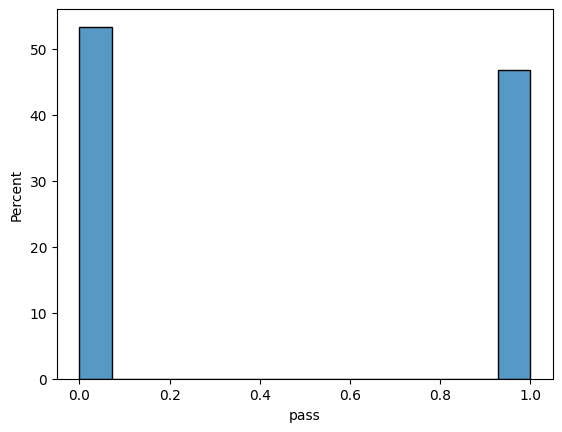

In [230]:
sns.histplot(df_clean['pass'], stat='percent')

around 53 % of the students did not pass the test, 47 % passed it

#### H1: Women are more likely to pass the test than men <br>

pass    False  True 
sex                 
Female    918    363
Male     1747   1972


<Axes: xlabel='sex'>

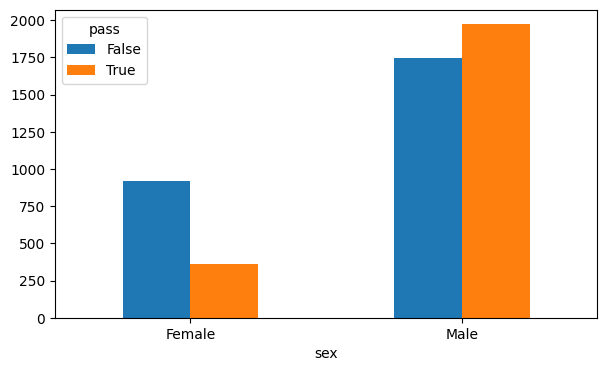

In [231]:
# create a crosstab of sex and pass
CrosstabResult=pd.crosstab(index=df_clean['sex'],columns=df_clean['pass'])
print(CrosstabResult)
 
# Grouped bar chart between sex and pass
CrosstabResult.plot.bar(figsize=(7,4), rot=0)

<Axes: xlabel='sex'>

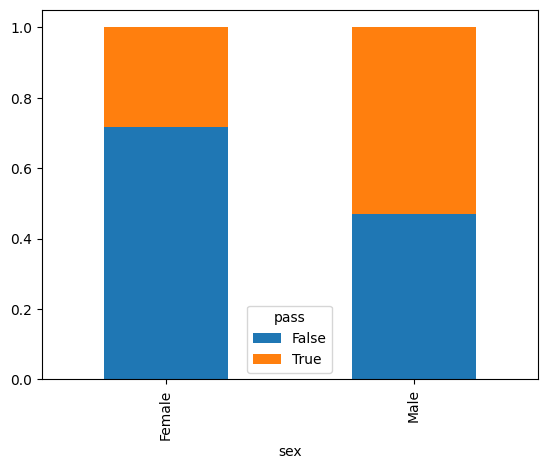

In [232]:
df_clean.groupby(['sex'])['pass'].value_counts(normalize=True).unstack('pass').plot.bar(stacked=True)

The male students seem to pass the test more often than the female students

#### H2: coming from Japan will increase the likelihood of passing the test 

pass         False  True 
country                  
Australia       72     62
Finland         28     17
France          65     63
Italy           84     61
Japan         2147   1875
Mexico          37     36
New Zealand     66     65
Spain           33     26
UK              65     58
USA             68     72


<Axes: xlabel='country'>

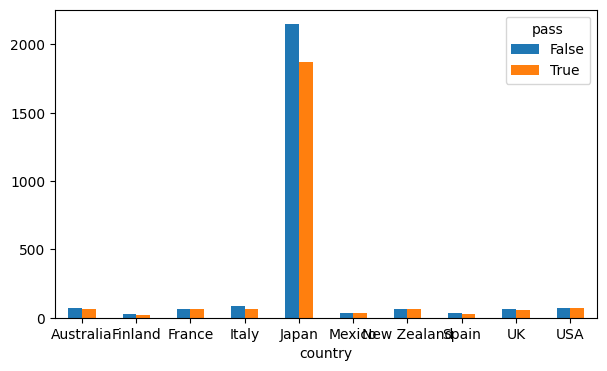

In [233]:
# create a crosstab of country and pass
CrosstabResult=pd.crosstab(index=df_clean['country'],columns=df_clean['pass'])
print(CrosstabResult)
 
# Grouped bar chart between sex and pass
CrosstabResult.plot.bar(figsize=(7,4), rot=0)

Because students from Japan are overrepresented in the data set, to interpret the data it must be in percentage

In [234]:
# total amount of students by country
df_total = df_clean.country.value_counts()
df_total

country
Japan          4022
Italy           145
USA             140
Australia       134
New Zealand     131
France          128
UK              123
Mexico           73
Spain            59
Finland          45
Name: count, dtype: int64

In [235]:
# percentage of students who passed and who did not passed grouped by country

df_clean.groupby(['country'])['pass'].value_counts(normalize=True) * 100


country      pass 
Australia    False    53.731343
             True     46.268657
Finland      False    62.222222
             True     37.777778
France       False    50.781250
             True     49.218750
Italy        False    57.931034
             True     42.068966
Japan        False    53.381402
             True     46.618598
Mexico       False    50.684932
             True     49.315068
New Zealand  False    50.381679
             True     49.618321
Spain        False    55.932203
             True     44.067797
UK           False    52.845528
             True     47.154472
USA          True     51.428571
             False    48.571429
Name: proportion, dtype: float64

<Axes: xlabel='country'>

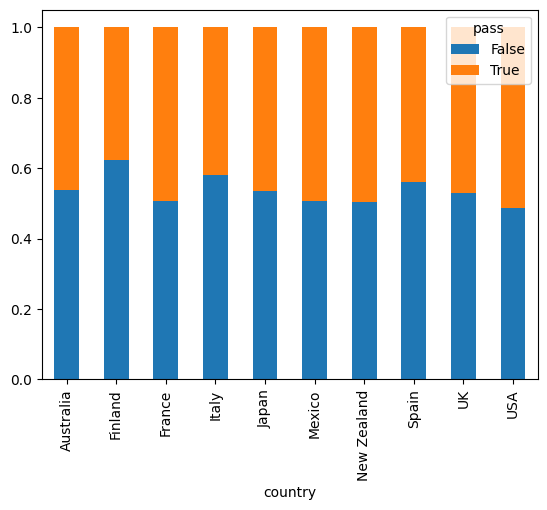

In [236]:
df_clean.groupby(['country'])['pass'].value_counts(normalize=True).unstack('pass').plot.bar(stacked=True)

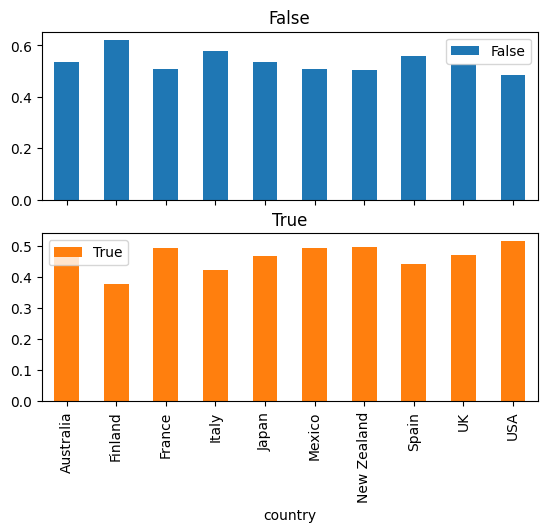

In [237]:
axes = df_clean.groupby(['country'])['pass'].value_counts(normalize=True).unstack('pass').plot.bar(subplots=True)
#axes[1].legend(loc=2) 


Japan is not even under the top 5 of Countries, where students pass the test most. The top five countries are
* France
* Australia
* USA
* New Zealand 
* Mexico

But the differences between the Countries aren't very large, so the impact of country doesn't seem to be that high.

#### H3: the more hours the students studied, the more likely they passed the test 

<Axes: >

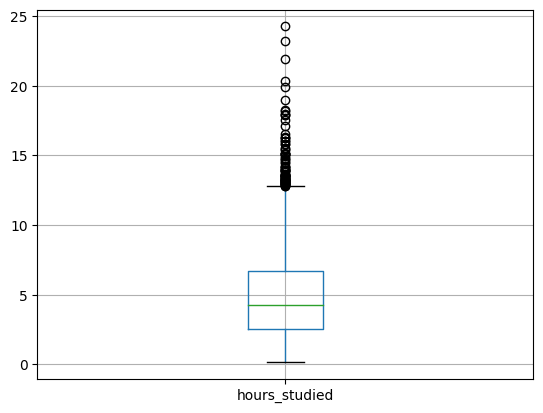

In [238]:
# distribution of the columns 'hours_studied'

df_clean.boxplot(column='hours_studied')

as we can see here, hours_studied has a lot of outliers. If there would be more time, I would have a closer look at the outliers and think about if it is necessary to throw some of them out

<Axes: title={'center': 'hours_studied'}, xlabel='pass'>

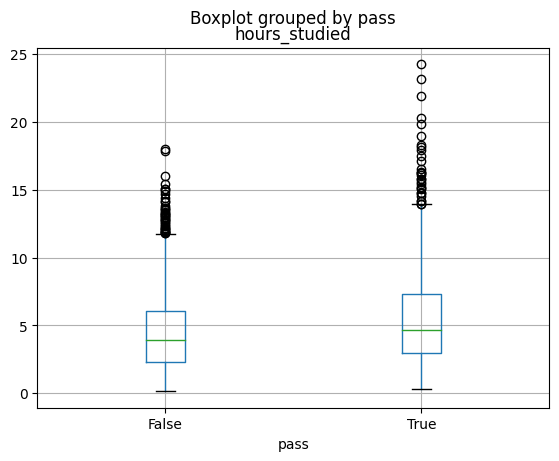

In [239]:
# let's see, if the hours, the students have studied, seem to have an impact on passing the test 

df_clean.boxplot(column='hours_studied', by='pass')

here you can see, that the students, who studied more hours, are passed the test more often (but again mentioned the high number of outliers, espeacially in regarding the students, who passed the test).
The students who passed the test studied mainly between 3 and 7.5 hours, students who didn't pass the test studied between 2.5 and 6 hours.

#### H4: students who doing the dojo class or the test prep will pass the test more likely 

##### 1st: dojo class

pass        False  True 
dojo_class              
False        2218   1300
True          447   1035


<Axes: xlabel='dojo_class'>

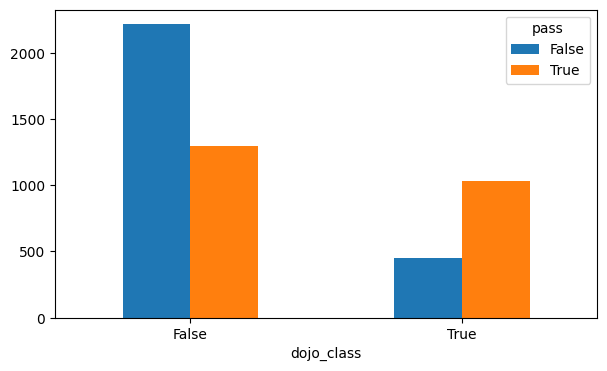

In [240]:
# create a crosstab of dojo_class and pass
CrosstabResult=pd.crosstab(index=df_clean['dojo_class'],columns=df_clean['pass'])
print(CrosstabResult)
 
# Grouped bar chart between dojo_class and pass
CrosstabResult.plot.bar(figsize=(7,4), rot=0)

<Axes: xlabel='dojo_class'>

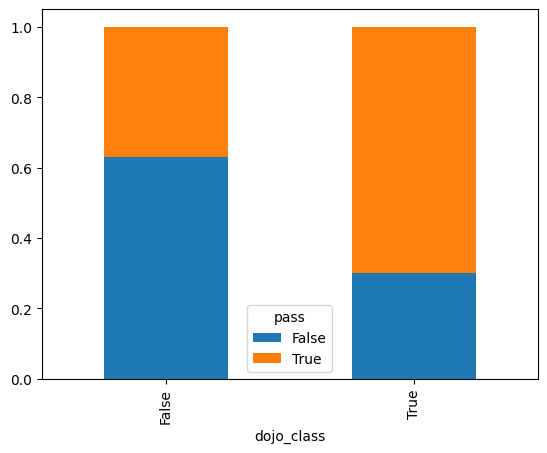

In [241]:
df_clean.groupby(['dojo_class'])['pass'].value_counts(normalize=True).unstack('pass').plot.bar(stacked=True)

# example how to optimize plot furthermore
# cross_tab_prop.plot(kind='bar', 
#                     stacked=True, 
#                     colormap='tab10', 
#                     figsize=(10, 6))

# plt.legend(loc="upper left", ncol=2)
# plt.xlabel("Release Year")
# plt.ylabel("Proportion")
# plt.show()

More than 70 % of the students, who participated in the dojo class passed the test. So the dojo class seems to have a high impact on passing the test.

##### 2nd: Test prep

pass       False  True 
test_prep              
False       2177   1809
True         488    526


<Axes: xlabel='test_prep'>

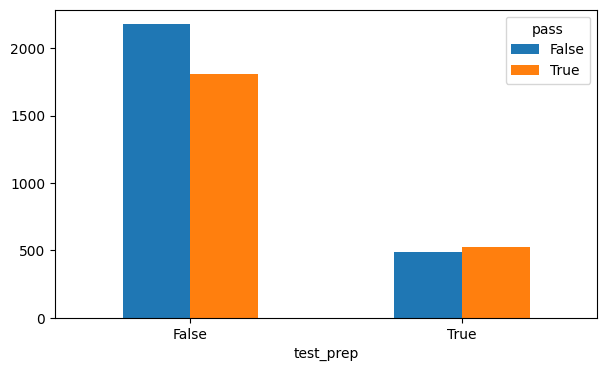

In [242]:
# create a crosstab of test_prep and pass
CrosstabResult=pd.crosstab(index=df_clean['test_prep'],columns=df_clean['pass'])
print(CrosstabResult)
 
# Grouped bar chart between test_prep and pass
CrosstabResult.plot.bar(figsize=(7,4), rot=0)

<Axes: xlabel='test_prep'>

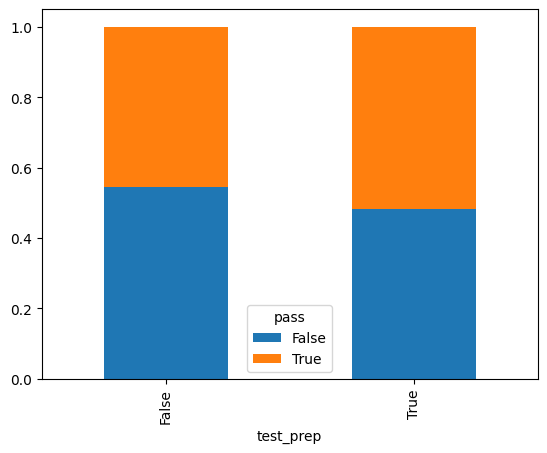

In [243]:
df_clean.groupby(['test_prep'])['pass'].value_counts(normalize=True).unstack('pass').plot.bar(stacked=True)

There is not a large effect of the test_prep course regarding passing the test.

#### Age

<Axes: >

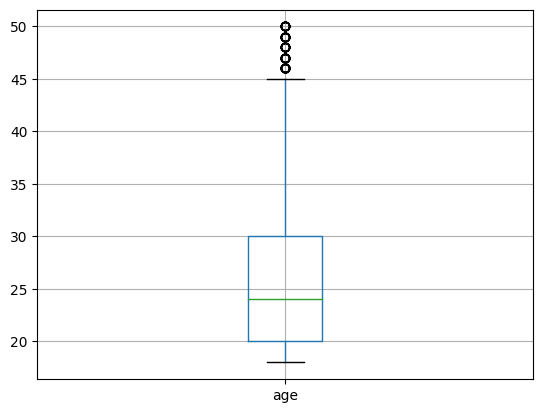

In [244]:
# distribution of age

df_clean.boxplot(column='age')

<Axes: xlabel='age'>

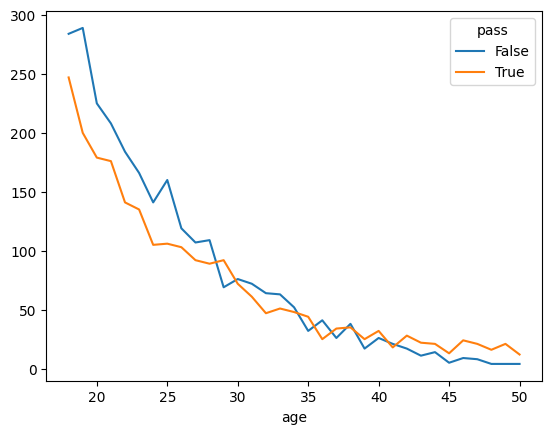

In [245]:
# plotting passing the test by age in absolute values

df_clean.groupby(['age'])['pass'].value_counts().unstack('pass').plot.line()

<Axes: xlabel='age'>

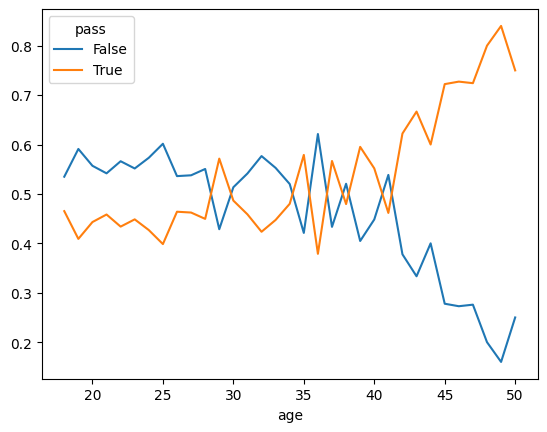

In [246]:
# plotting passing the test by age in percentage

df_clean.groupby(['age'])['pass'].value_counts(normalize=True).unstack('pass').plot.line()

people below 30 seem to fail the test more like and people above around 37 seem to pass it very likely. 

### Summary of EDA:
* male seem to pass the test more likely than female
* the country doesn't seem to have a strong effect on passing the test or not; but three of the top five countries are english speaking, maybe the language has a stronger effect
* the amount of hours, the student studied, seems to have an effect, but not a very strong
* if the students participated in the dojo class or not seems to have a great influence on passing the test; when they participated, they pass it way more likely; if they participated in the test prep course doesn't seem to make a difference
* the age seems to play a role especially when the students are younger (under 27 more likely to fail) or when they are older (above 37 more likely to pass)

### Have a look at the correlations of the columns


In [259]:
# herefor we need to change the string values of the categorical variables to 0 and 1
feature_list = ['dojo_class', 'test_prep', 'pass']
df_clean[feature_list] = df_clean[feature_list].replace(['True', 'False']).astype(int)
df_clean.head()

,sex,lang,country,age,hours_studied,dojo_class,test_prep,pass
0,Male,Japanese,Japan,20,10.578594,1,0,1
1,Male,Japanese,Japan,22,7.814520,0,0,1
2,Male,Japanese,Japan,27,4.213682,0,0,1
3,Male,Japanese,Japan,24,NaN,0,0,1
4,Female,Japanese,Japan,21,3.248907,0,0,0


In [261]:
df_clean['sex'] = df_clean['sex'].replace(['Male', 'Female'], [0, 1]).astype(int)
df_clean.head()

,sex,lang,country,age,hours_studied,dojo_class,test_prep,pass
0,0,Japanese,Japan,20,10.578594,1,0,1
1,0,Japanese,Japan,22,7.814520,0,0,1
2,0,Japanese,Japan,27,4.213682,0,0,1
3,0,Japanese,Japan,24,NaN,0,0,1
4,1,Japanese,Japan,21,3.248907,0,0,0


In [262]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   sex            5000 non-null   int64   
 1   lang           5000 non-null   category
 2   country        5000 non-null   category
 3   age            5000 non-null   int64   
 4   hours_studied  3018 non-null   float64 
 5   dojo_class     5000 non-null   int64   
 6   test_prep      5000 non-null   int64   
 7   pass           5000 non-null   int64   
dtypes: category(2), float64(1), int64(5)
memory usage: 244.9 KB


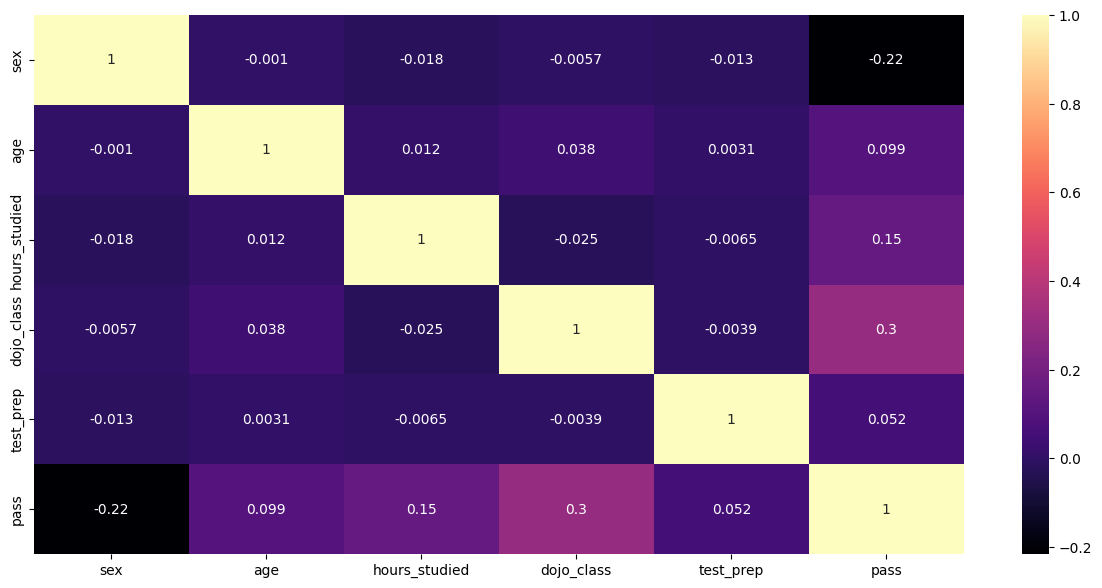

In [267]:
features = df_clean.drop(['lang', 'country'], axis=1)
corr_matrix = features.corr()

plt.figure(figsize=(15,7))
sns.heatmap(corr_matrix, annot=True ,cmap="magma")
plt.show()

There doesn't seem to be very strong correlations between each variables. Dojo Class has the highest correlation with 0.3, after that follows sex with -0.22 and hours_studied with 0.15. 

(Categorical features like language and country can't be used for a correlation/heatmap)

#### Feature engineering and further data cleaning necessary for creating model

In [268]:
# replace missing values
df_clean.isnull().sum()

sex                 0
lang                0
country             0
age                 0
hours_studied    1982
dojo_class          0
test_prep           0
pass                0
dtype: int64

in 'hours_studied' we have 1982 missing values, which we will replace with the mean value of 'hours_studied'

In [269]:
df_clean['hours_studied'].fillna(df_clean['hours_studied'].mean(), inplace=True)

In [270]:
df_clean.isnull().sum()

sex              0
lang             0
country          0
age              0
hours_studied    0
dojo_class       0
test_prep        0
pass             0
dtype: int64

no missing values left

In [271]:
# creating dummy variables out of Country and language
df_clean = pd.get_dummies(df_clean, drop_first=True, dtype=float)
df_clean.head(10)

,sex,age,hours_studied,dojo_class,test_prep,pass,lang_Finnish,lang_French,lang_Italian,lang_Japanese,lang_Spanish,country_Finland,country_France,country_Italy,country_Japan,country_Mexico,country_New Zealand,country_Spain,country_UK,country_USA
0,0,20,10.578594,1,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0,22,7.814520,0,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0,27,4.213682,0,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,24,4.964076,0,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1,21,3.248907,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0,18,4.964076,0,0,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,1,23,11.562409,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0,19,4.079594,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,24,4.964076,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0,18,4.964076,1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


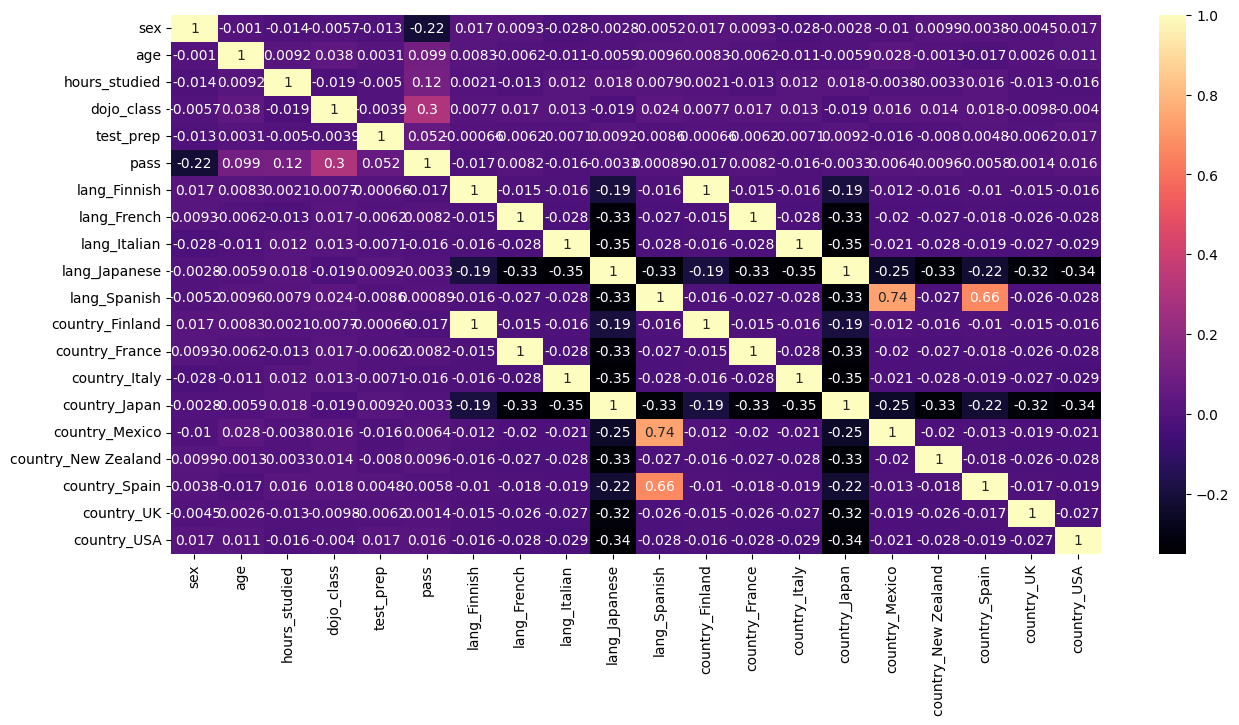

In [272]:
corr_matrix = df_clean.corr()

plt.figure(figsize=(15,7))
sns.heatmap(corr_matrix, annot=True ,cmap="magma")
plt.show()

as we can see here, as already thought, language and country are highly correlated. So we won't use both in the model.

## Part 2: Model Creation
Create a model that can predict whether or not a student will pass the test. Use the
provided data set to train your model and test its accuracy. You have free choice of
programming language, algorithm, and tools.

#### Baseline model

As a first baseline model I have chosen a simple decision tree, because no scaling is needed, it's robust on outliers and easy to interpret.

In [275]:
# defining X and y(the target variable)
X = df_clean.drop('pass', axis=1)
y = df_clean['pass']

In [302]:
# splitting data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [303]:
dec_tree = DecisionTreeClassifier(random_state = 42)


In [304]:
dec_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [306]:
y_pred_test = dec_tree.predict(X_test)
y_pred_train= dec_tree.predict(X_train)

In [307]:
# Function to calculate accuracy 
def cal_accuracy(y_test, y_pred): 
    ''' 
    calculates the accuracy score to evaluate the model by using y_test and y_pred
    prints out a confusion matrix
    prints out a classification report with f1 score, precision and recall values
    '''
    
    print("-----"*15)
    print("Confusion Matrix: \n", 
        confusion_matrix(y_test, y_pred)) 
    
    print("-----"*15)
    print ("Accuracy : \n", 
    accuracy_score(y_test, y_pred) * 100) 
    
    print("-----"*15)
    print("Report : \n", 
    classification_report(y_test, y_pred)) 

In [308]:
cal_accuracy(y_test, y_pred_test)

---------------------------------------------------------------------------
Confusion Matrix: 
 [[439 204]
 [253 354]]
---------------------------------------------------------------------------
Accuracy : 
 63.44
---------------------------------------------------------------------------
Report : 
               precision    recall  f1-score   support

           0       0.63      0.68      0.66       643
           1       0.63      0.58      0.61       607

    accuracy                           0.63      1250
   macro avg       0.63      0.63      0.63      1250
weighted avg       0.63      0.63      0.63      1250



with an f1 score of 0.61 (0 is worst, 1 is best) and an accuracy of 63.44 %, this model performs already quit well, but it could be better. Let's do some further modelling. 

In [313]:
# defining X and y(the target variable)
X2 = df_clean.drop(['pass', 'lang_Finnish', 'lang_French', 'lang_Italian', 'lang_Japanese',
       'lang_Spanish'], axis=1)
y = df_clean['pass']


In [315]:
# splitting data into train and test data
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, random_state=42)

In [316]:
dec_tree2 = DecisionTreeClassifier(random_state = 42)

In [317]:
dec_tree2.fit(X2_train, y_train)

DecisionTreeClassifier(random_state=42)

In [321]:
y_pred_test2 = dec_tree2.predict(X2_test)
y_pred_train2= dec_tree2.predict(X2_train)

In [322]:
cal_accuracy(y_test, y_pred_test2)

---------------------------------------------------------------------------
Confusion Matrix: 
 [[446 197]
 [254 353]]
---------------------------------------------------------------------------
Accuracy : 
 63.92
---------------------------------------------------------------------------
Report : 
               precision    recall  f1-score   support

           0       0.64      0.69      0.66       643
           1       0.64      0.58      0.61       607

    accuracy                           0.64      1250
   macro avg       0.64      0.64      0.64      1250
weighted avg       0.64      0.64      0.64      1250



In [358]:
#after choosing the features to work with, now we do some further model preparation 
dec_tree3 = DecisionTreeClassifier(max_depth=3, min_samples_leaf = 5)
dec_tree3.fit(X2_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)

In [359]:
y_pred_test3 = dec_tree3.predict(X2_test)

In [360]:
cal_accuracy(y_test, y_pred_test3)

---------------------------------------------------------------------------
Confusion Matrix: 
 [[523 120]
 [300 307]]
---------------------------------------------------------------------------
Accuracy : 
 66.4
---------------------------------------------------------------------------
Report : 
               precision    recall  f1-score   support

           0       0.64      0.81      0.71       643
           1       0.72      0.51      0.59       607

    accuracy                           0.66      1250
   macro avg       0.68      0.66      0.65      1250
weighted avg       0.68      0.66      0.66      1250



In [361]:
#choosing the entropy instead of giny 
dec_tree4 = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf = 5)
dec_tree4.fit(X2_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5)

In [362]:
y_pred_test4 = dec_tree4.predict(X2_test)

In [363]:
cal_accuracy(y_pred_test4, y_test)

---------------------------------------------------------------------------
Confusion Matrix: 
 [[524 300]
 [119 307]]
---------------------------------------------------------------------------
Accuracy : 
 66.47999999999999
---------------------------------------------------------------------------
Report : 
               precision    recall  f1-score   support

           0       0.81      0.64      0.71       824
           1       0.51      0.72      0.59       426

    accuracy                           0.66      1250
   macro avg       0.66      0.68      0.65      1250
weighted avg       0.71      0.66      0.67      1250



In [375]:
# Fit and evaluate model without hyperparameter tuning using cross validation and unscaled data 
sgd_classifier = SGDClassifier(random_state=42)
scores = cross_val_score(sgd_classifier, X2_train, y_train, cv=5, n_jobs=-1) #change scoring to accuracy

# Evaluation 
print('Score (unscaled):', round(scores.mean(), 4))

Score (unscaled): 0.6275


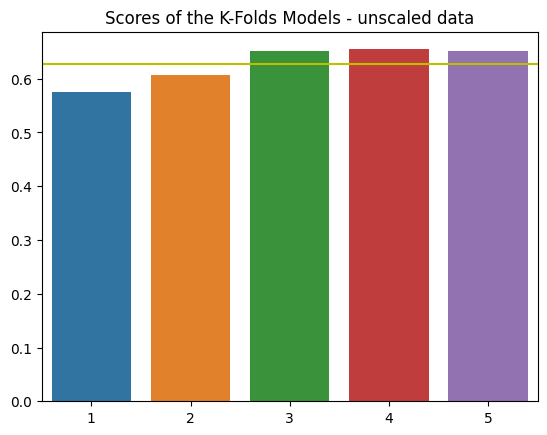

In [369]:
# plotting the scores and average score
plt.axhline(y=scores.mean(), color='y', linestyle='-')
sns.barplot(x=[1,2,3,4, 5],y=scores).set_title('Scores of the K-Folds Models - unscaled data');

* deleting correlated language variables increased the accuracy a tiny bit
* deleting also the country, decreased the evaluation metrics, so I leave country in
* deleting test_prep also decreased the evaluation metrics, so we keep it in

## Part 3: Reporting


By using this Model you can predict quite well, if a student will be able to pass the test or not. 
Future work and recommendations:
* the dojo class seem to have the strongest effect on passing the test. Encourage the students even more to participate on this test (more advertising, offer more dojo classes at different times instead of prep course, ...)
* try to encourage especially the younger students to participate on the course and support them (as well as female students)

* do some more hyperparameter tuning on the model to make it better or choose an ensemble method like random forest or different models like logistic regression or knn neighbors
* have a closer look at outliers, especially at hours_learned
* scaling country? because of Japan is overrepresented; depends on the model)